# 환경설정

In [ ]:
# imports
import argparse
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm, trange

In [ ]:
# 환경 설정
# seed값을 동일하게 해준다면 랜덤넘버제너레이팅 하는것도 동일한 값으로 나오게된다.
args = {
    # random seed value
    "seed": 1234,
    # number of vocab : 단어사전의 크기 
    "n_vocab": 32007,
    # number of input sequence : 입력 피처 수 
    "n_seq": 67,
    # hidden size : 단어 벡터의 깊이, 통상 128, 256 등으로 지정  
    "d_model": 128,
    # number of output 0이냐 1이냐 따라서 2로 지정함
    "n_out": 2
}
args = argparse.Namespace(**args)

print(args)

Namespace(d_model=128, n_out=2, n_seq=67, n_vocab=32007, seed=1234)


In [ ]:
# random seed 설정 위에서 seed를 1234로했져?
random.seed(args.seed)
np.random.seed(args.seed)
tf.random.set_seed(args.seed)

# 1.Data 준비

착안(중요하게 생각해야할) 사항 : 데이터 탐색을 통해서 입력 sentece 토큰의 길이를 얼마로 할 것인지 n_seq를 결정 

In [ ]:
# 입력 문장
# n_seq는 4로 통일되고, 3개 단어가 있는건 패딩작업을 해주면 된다?
sentences = [
    "신차 정말 좋아요",  # 3개의 단어, 따라서 단어단위로 토큰을 나눴다면 입력변수 피쳐가 3개로 입력되어야함
    "신차 속도감 너무 안좋아", # 4개의 단어, 따라서 단어단위로 토큰을 나눴다면 입력변수 피쳐가 4개로 입력되어야함
    "신차 디자인 연비 좋아요",  # 위와 마찬가지
    "신차 엉터리로 개발했네요"  # 위와 마찬가지
]

# 출력 정답
targets = [1, 0, 1, 0]  # 부정(0), 긍정(1)

In [ ]:
# 처리할 text 데이터 준비
pd.DataFrame(sentences, targets)

,0
1,신차 정말 좋아요
0,신차 속도감 너무 안좋아
1,신차 디자인 연비 좋아요
0,신차 엉터리로 개발했네요


In [ ]:
id_to_label = {0: "부정", 1: "긍정"}

In [ ]:
# 학습때 사용할 데이터 뽑기

train_sentences = sentences[:2]
train_targets = targets[:2]

train_sentences, train_targets

(['신차 정말 좋아요', '신차 속도감 너무 안좋아'], [1, 0])

In [ ]:
valid_sentences = sentences[2:3]
valid_targets = targets[2:3]

valid_sentences, valid_targets

(['신차 디자인 연비 좋아요'], [1])

In [ ]:
test_sentences = sentences[3:]
test_targets = targets[3:]

test_sentences, test_targets

(['신차 엉터리로 개발했네요'], [0])

트레인 데이터, 벨리데이션 데이터, 테스트 데이터로 구분을 해줬습니다.

In [ ]:
# 입력 단위 토큰 수 
args.n_seq = 4

# 각각 하나의 텍스트가 4개의 토큰으로 입력하게 된다.
# 토큰이 3개인것은 패딩이 1개씩 추가되겠죠 위에선 1번과 4번째 문장ㅇㅇ

# 2.Vocabulary

착안사항 : 단어사전을 통해서 n_vocab 사이즈 결정(이것이 결정되어야만 모델링할때 이값이 참조가 되기 때문에 잘 결정할것)

In [ ]:
words = []

for line in sentences:
    for w in line.split():
        words.append(w)
words

['신차',
 '정말',
 '좋아요',
 '신차',
 '속도감',
 '너무',
 '안좋아',
 '신차',
 '디자인',
 '연비',
 '좋아요',
 '신차',
 '엉터리로',
 '개발했네요']

In [ ]:
# 중복 제거하고 유니크한 단어로 만들기
words = list(dict.fromkeys(words))
words

['신차', '정말', '좋아요', '속도감', '너무', '안좋아', '디자인', '연비', '엉터리로', '개발했네요']

In [ ]:
word_to_id = {"[PAD]": 0, "[UNK]": 1}
for w in words:
    if w not in word_to_id:
        word_to_id[w] = len(word_to_id)
word_to_id

{'[PAD]': 0,
 '[UNK]': 1,
 '개발했네요': 11,
 '너무': 6,
 '디자인': 8,
 '속도감': 5,
 '신차': 2,
 '안좋아': 7,
 '엉터리로': 10,
 '연비': 9,
 '정말': 3,
 '좋아요': 4}

In [ ]:
id_to_word = {_id:w for w, _id in word_to_id.items()}
id_to_word

# 이 수치화 시킨것을 바로쓸순없다. 그래서 
# 단어사전에 있는 2,3,4에서 신차 정말 좋아요만 입력해놓으면
# 새차라는 단어가 들어왔을때 새차라는 단어를 알려면
# 신차라는 단어를 분해해야한다. 단어사전에 나와있는말 말고도
# 다른단어가왔을때 유사성을 갖는지아닌지 이해할수있다.
# 따라서 depth를 추가해주는것이다. 그런것을 d_model이라한다.)


{0: '[PAD]',
 1: '[UNK]',
 2: '신차',
 3: '정말',
 4: '좋아요',
 5: '속도감',
 6: '너무',
 7: '안좋아',
 8: '디자인',
 9: '연비',
 10: '엉터리로',
 11: '개발했네요'}

In [ ]:
args.n_vocab = len(word_to_id)
args

# n_seq는 67이었는데 4로 바꼈다.
# n_vocab은 위에서 32007개로 설정했는데, 12개로 바꼈다.
# 즉 우리가 실습할 내용으로 바꿔준것이다.

Namespace(d_model=128, n_out=2, n_seq=4, n_vocab=12, seed=1234)

# 3.Train, Valid, Test 데이터 생성

In [ ]:
def make_data(sentences, targets, n_seq=4):   # n_seq=4를 해줌으로써 똑같은 길이의 센텐스로 바꿔준다.
    inputs, labels = [], []

    for sentence, target in zip(sentences, targets):
        print(sentence, target)
        _input = [word_to_id[w] for w in sentence.split()]
        print(_input)
        _input = _input[:n_seq]
        _input += [0] * (n_seq - len(_input))
        print(_input)
        inputs.append(_input)

        _label = target
        labels.append(_label)

    inputs = np.array(inputs)
    labels = np.array(labels)
    
    return inputs, labels

In [ ]:
train_inputs, train_labels = make_data(train_sentences, train_targets)
train_inputs, train_labels

#결과해석: 첫번째껀 패딩이 붙어서 맨 마지막에 0이 들감. n_seq는 4로 해줬기때문에 4로 맞춰준것임
# array([1,0])은 1긍정 0부정이 들어갔ㄴ다는 것임.

신차 정말 좋아요 1
[2, 3, 4]
[2, 3, 4, 0]
신차 속도감 너무 안좋아 0
[2, 5, 6, 7]
[2, 5, 6, 7]


(array([[2, 3, 4, 0],
        [2, 5, 6, 7]]), array([1, 0]))

In [ ]:
train_inputs.shape, train_labels.shape

#결과해석: (2,4)는 2개의 리뷰값이고 n_seq=4 이다, (2,)는 2개의 라벨값

((2, 4), (2,))

In [ ]:
valid_inputs, valid_labels = make_data(valid_sentences, valid_targets)
valid_inputs, valid_labels

신차 디자인 연비 좋아요 1
[2, 8, 9, 4]
[2, 8, 9, 4]


(array([[2, 8, 9, 4]]), array([1]))

In [ ]:
test_inputs, test_labels = make_data(test_sentences, test_targets)
test_inputs, test_labels

# 단어수가 3개였기때문에 1자리를 0으로 패드가 채워줬죠ㅕ?

신차 엉터리로 개발했네요 0
[2, 10, 11]
[2, 10, 11, 0]


(array([[ 2, 10, 11,  0]]), array([0]))

In [ ]:
# d_model 단어벡터의 subword 3차원 깊이(통상 128, 256), 
# d_model은 각 단어들에 대한 3차원 깊이를 얘기한다. 깊이를 깊이할수록 
# 조금 더 복잡한 문제를 구별해 낼 수있는 고차원 모델을 만들수있다.

# n_out 출력변수, n_seq 입력피쳐(하나의 센텐스 입력 토큰수 max), n_vocab 단어사전 길이

# 이번 실습은 간단하게 n_seq와 구분되는 정도의 숫자 5로 해서 계산하는 과정을 알아보겠스빈다.
args.n_seq = 4
args.d_model = 5
args

# d_model값을 128, 256으로 할수있지만 오늘은 간단하게 5차원으로 할게
# n_out은 바이너리 데이터기때문에 2개만 할거고
# n_seq=4 는 4개의 입력변수만 입력할수 있도록 하겠다.
# n_vocab=12는 전체 보케부러리의 길이이다.(pad와 unk 포함임ㅇㅇ)
# 랜덤넘버제너레이팅을 위해 seed=1234로 지정했다.

Namespace(d_model=5, n_out=2, n_seq=4, n_vocab=12, seed=1234)

# 4.Modeling

인공지능 기반 텍스트 데이터 분석 분야에서 어떤 부분을 기획해야 하느냐 생각하면
1. 텍스트 데이터를 어떻게 임베딩할건지 
2. 실제 우리가 뉴럴네트웤의 어떤 모델을 활용할건지
3. 그 데이터를 적절히 추론하기 위해 어떤 아웃풋을 만들어낼건지

In [ ]:
def build_model(args):
    """
    동작만 하는 간단한 모델
    :param args: input args
    """
    inputs = tf.keras.layers.Input((args.n_seq,))  # (bs, n_seq) => (2, 4)가 됨  bs는 배치사이즈로 데이터의 개수를 나타냄
    # 가. 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)  # 이제 임베딩을 시킬건데 임베딩을 할때는 
                                                                       # n_vocab(32007)을 할거냐 아니면 바로위에서 정의한 
                                                                       # 패딩과 언노운 포함한 n_vocab(12)을 할거냐.. d_model은 5로 선정했죠?
                                                                       # 따라서 보켑사이즈와 모델의 깊이를 참조한 임베딩데이터를 만들면 3차원값이 된다.
    hidden = embedding(inputs)  # (bs, n_seq, d_model)
    ########################################################
    # RNN, CNN, Attention, Dense ...
    ########################################################
    # 나. 문장의 특징 추출
    pool = tf.keras.layers.GlobalMaxPooling1D()  # RNN이나 CNN을 거쳐 나온값을 가지고 추론을 위한 pooling단계를 거친다.
                                                 # 글로벌멕심풀링은 나온값중에 최대값을 참조하여 그 문장의 특징을 추출하는것임
    hidden = pool(hidden)
    # 다. 단어의 vector를 이용해서 정답 확률값 예측
    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)  # 활성화 함수인 softmax는 나온 두개의 값(0과 1)을 확률값으로 변환시키는것임
    outputs = linear(hidden)  # (bs, n_seq, n_out) n_out은 각각 0에 속할 확률값인지 1에 속할 확률값인지를 받아냄 
    # 라. 학습할 모델 선언
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

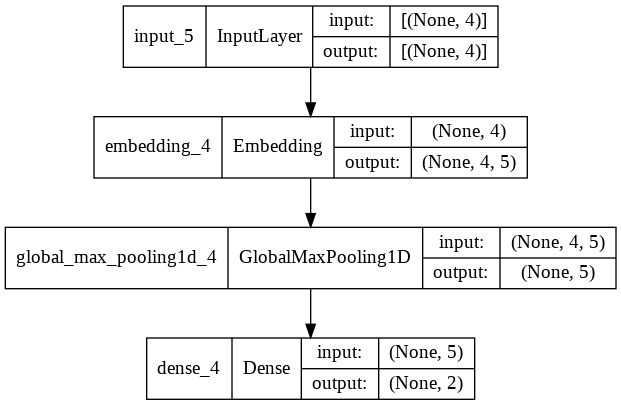

In [ ]:
# 모델 생성
model = build_model(args)
# 모델 내용 그래프 출력, none 부분은 입력 데이터 수 즉, bach size 로 생각 
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

# 첫번째 박스: 입력할때는 None,4가 있죠 -> 4개의 피쳐를 배치사이즈는 2x4의 형태로 입력한다.
# 두번째 박스: 2x4의 형태로 나온것을 가지고 임베딩을 시켜주는데, 히든 레이어로 입력하기 위해서
#              2x4데이터를 가지고 d_model을 5로 만들어줬다.
# 이제 적절한 뉴럴 네트웤을 거친다음에
# 세번째 박스: 멕스풀링을 해서 4개의 피쳐수의 특징중 가장 두드러진것을 꺼내온것을 가지고 
#              2x5의 아웃풋을 도출해 냅니다.
# 네번째 박스: 소프트 맥스 함수로 바로위의 아웃풋을 가지고 0일 확률과 1일 확률로
#              바꿔주고 그것을 가지고 0과 1의 값에 속할 확률로 출력한다.

# 이부분 다시듣고싶으면 58분 30초??부터 다시 듣도록

# 모델링 이해* (중간 과정이 어떻게 계산되는지 설명하기 위해 넣은 과정임 실제로는 이 부분 적용x 과제할때 안넣어도 되나봄)

In [ ]:
args

Namespace(d_model=5, n_out=2, n_seq=4, n_vocab=12, seed=1234)

In [ ]:
# 가. 입력 단어를 vector로 변환

# 영상 33분
embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
hidden = embedding(train_inputs)
hidden

<tf.Tensor: shape=(2, 4, 5), dtype=float32, numpy=
array([[[-0.04711794, -0.03869128, -0.00894965,  0.02723351,
         -0.03577739],
        [-0.02648449, -0.04523795, -0.01380389, -0.03168114,
         -0.01249317],
        [ 0.01537615, -0.04004092,  0.01148902,  0.03942684,
         -0.00338246],
        [-0.003052  ,  0.0146344 , -0.0423818 , -0.01079366,
         -0.02614037]],

       [[-0.04711794, -0.03869128, -0.00894965,  0.02723351,
         -0.03577739],
        [-0.00425016, -0.03753252,  0.03538778, -0.00160744,
          0.01576914],
        [-0.03659384,  0.02914334, -0.0006273 , -0.01253395,
          0.0056827 ],
        [ 0.01455701, -0.02878033,  0.01615823,  0.0288457 ,
         -0.03712509]]], dtype=float32)>

In [ ]:
# embedding weight
weight = embedding.get_weights()[0]
weight

array([[-0.003052  ,  0.0146344 , -0.0423818 , -0.01079366, -0.02614037],
       [-0.03315832, -0.00736512,  0.00761634, -0.04137301,  0.0122998 ],
       [-0.04711794, -0.03869128, -0.00894965,  0.02723351, -0.03577739],
       [-0.02648449, -0.04523795, -0.01380389, -0.03168114, -0.01249317],
       [ 0.01537615, -0.04004092,  0.01148902,  0.03942684, -0.00338246],
       [-0.00425016, -0.03753252,  0.03538778, -0.00160744,  0.01576914],
       [-0.03659384,  0.02914334, -0.0006273 , -0.01253395,  0.0056827 ],
       [ 0.01455701, -0.02878033,  0.01615823,  0.0288457 , -0.03712509],
       [ 0.00366353, -0.02076926, -0.00210817, -0.03703519, -0.03656179],
       [ 0.01500219,  0.03664818,  0.01508601,  0.04277892,  0.02896464],
       [-0.0252651 , -0.026425  , -0.04404253, -0.01328304, -0.03632405],
       [ 0.02781849,  0.03801772,  0.01230282,  0.04221109, -0.02857541]],
      dtype=float32)

In [ ]:
# numpy를 이용해서 직접 조회 (두 결과값 비교)
weight[train_inputs], hidden

(array([[[-0.04711794, -0.03869128, -0.00894965,  0.02723351,
          -0.03577739],
         [-0.02648449, -0.04523795, -0.01380389, -0.03168114,
          -0.01249317],
         [ 0.01537615, -0.04004092,  0.01148902,  0.03942684,
          -0.00338246],
         [-0.003052  ,  0.0146344 , -0.0423818 , -0.01079366,
          -0.02614037]],
 
        [[-0.04711794, -0.03869128, -0.00894965,  0.02723351,
          -0.03577739],
         [-0.00425016, -0.03753252,  0.03538778, -0.00160744,
           0.01576914],
         [-0.03659384,  0.02914334, -0.0006273 , -0.01253395,
           0.0056827 ],
         [ 0.01455701, -0.02878033,  0.01615823,  0.0288457 ,
          -0.03712509]]], dtype=float32),
 <tf.Tensor: shape=(2, 4, 5), dtype=float32, numpy=
 array([[[-0.04711794, -0.03869128, -0.00894965,  0.02723351,
          -0.03577739],
         [-0.02648449, -0.04523795, -0.01380389, -0.03168114,
          -0.01249317],
         [ 0.01537615, -0.04004092,  0.01148902,  0.03942684,
     

In [ ]:
# RNN, CNN, Attention, Linear ....

In [ ]:
# 나. 문장의 특징 추출 
tf.keras.layers.GlobalAvgPool1D()(hidden)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[-0.01531957, -0.02733394, -0.01341158,  0.00604638, -0.01944835],
       [-0.01835123, -0.0189652 ,  0.01049226,  0.01048445, -0.01286266]],
      dtype=float32)>

In [ ]:
hidden = tf.keras.layers.GlobalMaxPooling1D()(hidden)
hidden

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[ 0.01537615,  0.0146344 ,  0.01148902,  0.03942684, -0.00338246],
       [ 0.01455701,  0.02914334,  0.03538778,  0.0288457 ,  0.01576914]],
      dtype=float32)>

In [ ]:
# 다. 단어의 vector를 이용해서 입력 배치 순서대로 부정(0), 긍정(1) 확률값 예측
linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
outputs = linear(hidden)
outputs

# 1일 확률이 0.51로 더 높음

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.48959807, 0.51040196],
       [0.48407206, 0.515928  ]], dtype=float32)>

In [ ]:
# dense의 wieght, bias
weight, bias = linear.get_weights()
weight, bias

(array([[-0.6806258 ,  0.66341436],
        [ 0.00667012,  0.37747836],
        [-0.14185983,  0.4840834 ],
        [-0.7243631 ,  0.12499833],
        [-0.18615186, -0.1517908 ]], dtype=float32),
 array([0., 0.], dtype=float32))

In [ ]:
# numpy를 이용한 Wx + b
logits = np.matmul(hidden, weight) + bias
logits

array([[-0.0678063 ,  0.04709826],
       [-0.05007663,  0.0212659 ]], dtype=float32)

In [ ]:
# softmax 계산을 위한 준비 exp(x') / sum(exp(x))
numerator = np.exp(logits)
denominator = np.sum(numerator, axis=1, keepdims=True)
numerator, denominator

(array([[0.93444145, 1.048225  ],
        [0.9511566 , 1.0214937 ]], dtype=float32), array([[1.9826665],
        [1.9726503]], dtype=float32))

In [ ]:
# 두 결과값 비교
probs = numerator / denominator
probs, outputs

(array([[0.4713054 , 0.52869457],
        [0.48217195, 0.51782805]], dtype=float32),
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.47130543, 0.52869457],
        [0.48217195, 0.5178281 ]], dtype=float32)>)

# 5.Train

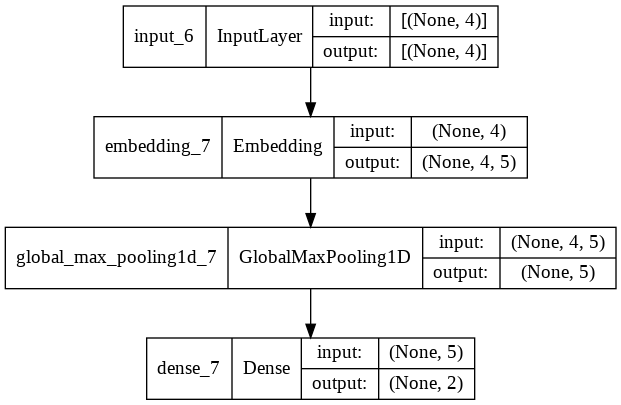

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# sparse_categorical_crossentropy은 입력된 데이터값을 가지고 긍정일 확률에 대한
# 부정일 확률의 기댓값 

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
save_weights = tf.keras.callbacks.ModelCheckpoint("sentence_calss.hdf5",
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger("sentence_calss.csv")

In [ ]:
# 모델 학습
history = model.fit(train_inputs, train_labels,
                    epochs=100,
                    batch_size=16,
                    validation_data=(valid_inputs, valid_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6893 - accuracy: 1.0000
Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to sentence_calss.hdf5
1/1 [==============================] - 1s 838ms/step - loss: 0.6893 - accuracy: 1.0000 - val_loss: 0.6980 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.6887 - accuracy: 1.0000
Epoch 00002: val_accuracy did not improve from 0.00000
1/1 [==============================] - 0s 29ms/step - loss: 0.6887 - accuracy: 1.0000 - val_loss: 0.6969 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 1.0000
Epoch 00003: val_accuracy did not improve from 0.00000
1/1 [==============================] - 0s 27ms/step - loss: 0.6882 - accuracy: 1.0000 - val_loss: 0.6959 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.6878 - accuracy: 1.0000
Epoch 00004: val_accuracy di

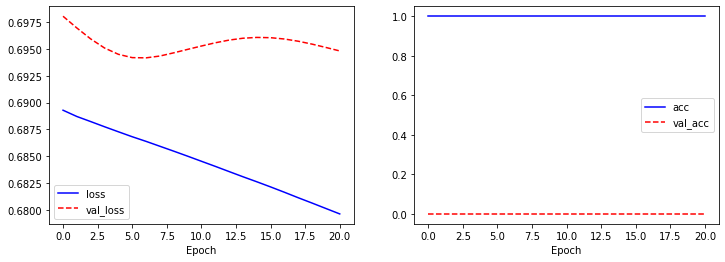

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b-', label='acc')
plt.plot(history.history['val_accuracy'], 'r--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

# 6.평가

In [ ]:
model = build_model(args)
model.load_weights("sentence_calss.hdf5")

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# 모델 평가
model.evaluate(test_inputs, test_labels)

1/1 [==============================] - 0s 180ms/step - loss: 0.6889 - accuracy: 1.0000


[0.6889405250549316, 1.0]

# 7.배포

In [ ]:
model = build_model(args)
model.load_weights("sentence_calss.hdf5")

In [ ]:
# 추론할 입력
string = '신차 정말 디자인 엉터리로'

In [ ]:
# 입력을 숫자로 변경
infer_input = [word_to_id[word] for word in string.split()]
infer_input

[2, 3, 8, 10]

In [ ]:
# numpy array 변환
infer_inputs = np.array([infer_input])
infer_inputs

array([[ 2,  3,  8, 10]])

In [ ]:
# 부정(0), 긍정(1) 추론
y_preds = model.predict(infer_inputs)
y_preds

# 결과해석: 0일확률, 1일확률인데 0일 확률이 좀더 높져?(부정일 확률)
# 값이 실행할때마다 다를수있으니 당황 ㄴㄴ

array([[0.5005948 , 0.49940524]], dtype=float32)

In [ ]:
# 확률의 max 값을 추론 값으로 결정
y_pred_class = np.argmax(y_preds, axis=1)
y_pred_class

array([0])

In [ ]:
id_to_label = {0: '부정', 1: '긍정'}

In [ ]:
# 각 예측 값에 대한 label string
for val in y_pred_class:
    print(id_to_label[val])

# 제대로된 예측이 나온듯 

부정


In [ ]:
# 위의 과정을 하나의 함수로 만든것임

def do_predict(word_to_id, id_to_label, model, string):
    tokens = string.split()[:4]

    # 입력을 숫자로 변경
    infer_input = [word_to_id.get(word, 1) for word in tokens]
    print(infer_input)

    # numpy array 변환
    infer_input += [0] * (4 - len(infer_input))
    infer_inputs = np.array([infer_input])
    print(infer_inputs)

    # 부정(0), 긍정(1) 추론
    y_preds = model.predict(infer_inputs)
    print(y_preds)

    # 확률의 max 값을 추론 값으로 결정
    y_pred_class = np.argmax(y_preds, axis=-1)[0]
    print(y_pred_class)
    # print(tokens)
    
    return id_to_label[y_pred_class]

In [ ]:
do_predict(word_to_id, id_to_label, model, string)

[2, 3, 8, 10]
[[ 2  3  8 10]]
[[0.5005948  0.49940524]]
0


'부정'

In [ ]:
# 신차 연비 좋아요, 엉터리로 개발했네요 등 
while True:
    print('input >> ', end='')
    string = input()
    string = string.strip()
    if not string:
        break
    result = do_predict(word_to_id, id_to_label, model, string)
    print(result)

KeyboardInterrupt: ignored

이와같이 입력데이터의 변화에 따라 배포를 시키면 다른 말을 쓰더라도 학습이 잘된것은 새로들어온 문장이 긍정적인지 부정적인지를 모델이 알아서 구별을 해준다. 신차를 개발해서 런칭을 헀다면, 여러 사람이 입력했던 데이터를 수집해서 인공지능에 의한 텍스트 데이터 분류모델을 만들고 그것을 배포해서 새로운 신차 개발이 됐을때, 새로 생길 리뷰들에게 바로 이 모델을 적용하면 긍정적 의견 부정적 의견으로 바로바로 분류 해낼수있다. 분류해낸걸 가지고 토픽 분석을 한다던지 워드클라우딩을 한다던지 해서 요약된 정보로 신속하게 정리를해서 적절한 대응이 가능해진다. 

요약하면 텍스트 데이터의 신경망 모델링은 크게 옆 목차의 데이터 준비과정, 보케뷸러리, 트레닝 벨리 테스트 데이터로 구분해서 생성하고, 임베딩 시켜줄수 있는 준비 그리고 적절한 모델을 선택해서 모델링을 해주고, 학습을 시켜서 평가하고 적절하다면 배포해서 이러한 워크플로우 과정을 거친다.
가장 중요한것은 완전 첫번째 코드값에 넣은 시드값 n_vocab(참조할 단어사전의 크기)
n_seq(입력시퀀스 즉 입력할 데이터에 대한 길이를 얼만큼으로 설정할건지 이때 부족한것은 패드로 채워주고 긴것은 적절한 크기로 잘라줌. 리뷰데이터가 잘 입력될 수 있도록 1차적으로 정리해주는 과정을 거친다.) n_model을 통해 얼만큼의 깊이있는 모델로 다룰것이냐. 오늘은 편의상 5로 설정해 5차원으로 하였다. n_out은 바이너리 데이터기 때문에 2이다. 